# Apply Trained Model on All Images and Collect Measurements

This notebook applies pre-trained model to all images and save tables.

It also builds a master table and provide plots.

# Suggested folder structure
```
Data Folder
|
├─ Patient 8
|    |
|    ├─ Day 9
|    |    |
|    |    ├─ media1.tif
|    |    ├─ media2.tif
|    |    ⁞
|    |
|    └─ Day 21
|         |
|         ├─ media1.tif
|         ├─ media2.tif
|         ⁞
|
├─ Patient 10
|    |
|    ├─ Day 9
|    |    |
|    |    ├─ media1.tif
|    |    ├─ media2.tif
|    |    ⁞
|    |
|    └─ Day 21
|         |
|         ├─ media1.tif
|         ├─ media2.tif
|         ⁞
⁞
```

In [3]:
from pathlib import Path
from skimage.io import imread, imsave
import napari_simpleitk_image_processing as nsitk
import numpy as np
import apoc
from napari_skimage_regionprops import regionprops_table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from utilities import refine_labels

## 1. Provide inputs

Folder to images and number of images in training and validation sets

In [4]:
folder_path = r"D:\Datasets\Claudia Dagostino\data"

folder_path = Path(folder_path)

# Load min_area json file, get min_area key-value par and store it in min_area variable
# print message if file is not found
try:
    with open(folder_path / 'min_area.json') as f:
        min_area = json.load(f)['min_area']
# Handle exception in case file is not found
except FileNotFoundError:
    print(f"Warning! 'min_area.json' file not found in {folder_path}! Using default value of 1000.")
    min_area = 1000

print(f"min_area = ", min_area)

min_area =  1000


In [5]:
image_path_list = []
# Iterate over all paths inside folder path
for path in folder_path.rglob("*"):
     # Check if path is a .tif file
    if (path.is_file() and path.suffix == '.tif'):
         # check if file path does not include 'train', 'validation', 'train_annotations' or 'control' folder
        if ('train' not in path.parts) and ('validation' not in path.parts) and ('Outputs' not in path.parts) and ('train_annotations' not in path.parts) and ('control' not in path.parts):
            image_path_list.append(path)

In [6]:
model_path = folder_path / 'my_model.cl'

## Define a function containing your workflow



In [7]:

def workflow(image_path, model_path, min_area):
    image = imread(image_path)
    model = apoc.PixelClassifier(opencl_filename=model_path)

    # Provide standard deviation filter as extra channel
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])

    # Get model prediction
    prediction = model.predict(image=image_stack)

    # Instance Segmentation and Post-process labels
    labels_post_processed = refine_labels(prediction, min_area)
    
    # Get size measurements
    table = regionprops_table(
        image,
        labels_post_processed,
        size=True,
        shape=True,
        intensity=False,
        napari_viewer=None,
    )
    
    return labels_post_processed, table



## Batch Processing
For each path in the list, read the image, apply the workflow and save the results in an "Output" folder.

Labeled images and tables are saved inside the Output folder with the same name as the original image + "\_labels" or "\_table", respectively. 


In [8]:
image_path_list

[WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/organoids_B070799EFE6-C990-4640-8A06-7F871FDA031F.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/organoids_B08D1CF1EC4-FE5B-43FE-9067-B4964B21ED4D.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/organoids_C08696DB4E4-09A0-4C21-8CF1-75061F354A13.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/organoids_C12040B1EC8-6DEE-4489-9D27-744A93C5F2B5.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/spheroids_B05E041C2F1-4028-4AC5-BF10-9759D9FBF0D8.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/spheroids_B07E3FCE222-3592-4F7B-8842-1E86B15EC714.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/spheroids_B122EB30DB6-29CF-48CF-B80C-30FDC34780A5.tif'),
 WindowsPath('D:/Datasets/Claudia Dagostino/data/Patient 3/Before/spheroids_B14EA5AF000-64CA-404E-94A2-34CBB4E16669.tif'),
 WindowsPath('D:

In [9]:
master_df = pd.DataFrame()
# iterate over list of paths
for image_path in image_path_list:
    # applies workflow on image
    label_image, table = workflow(image_path, model_path, min_area)
    # Create an empty "Outputs" folder (if not there already)
    output_folder_path = Path(image_path.parent, 'Outputs')

    output_folder_path.mkdir(exist_ok = True)
    
    # Create a "image_labels.tif" path
    output_label_image_path = Path(output_folder_path, image_path.stem + '_labels.tif')
    # Store the label_image in the created "image_labels.tif" path
    imsave(output_label_image_path, label_image)
    
    # Create a "image_table.csv" path
    output_table_path = Path(output_folder_path, image_path.stem + '_table.csv')
    # Store the table in the created "image_table.csv" path
    table.to_csv(output_table_path)

    table['file_name'] = image_path.stem[:13] # Change this once/if same file names are used
    time_of_acquisition = image_path.parent.stem
    table['time_of_acquisition'] = time_of_acquisition
    group = image_path.parent.parent.stem
    table['group'] = group
    master_df = pd.concat([master_df, table])

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_7708\2738699029.py:14: UserWarning: D:\Datasets\Claudia Dagostino\data\Patient 3\Before\Outputs\organoids_B070799EFE6-C990-4640-8A06-7F871FDA031F_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_7708\2738699029.py:14: UserWarning: D:\Datasets\Claudia Dagostino\data\Patient 3\Before\Outputs\organoids_B08D1CF1EC4-FE5B-43FE-9067-B4964B21ED4D_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_7708\2738699029.py:14: UserWarning: D:\Datasets\Claudia Dagostino\data\Patient 3\Before\Outputs\organoids_C08696DB4E4-09A0-4C21-8CF1-75061F354A13_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_7708\2738699029.py:14: UserWarning: D:\Datasets\Claudia Dagostino\data\Patient 3\Before\Outputs\organoids_C12040B1EC8-6DEE-4489-

Calculate the log of the areas for better plot visualization

In [12]:
master_df['log_of_area'] = np.log10(master_df['area'])

In [13]:
master_df

,label,area,bbox_area,equivalent_diameter,convex_area,extent,local_centroid-0,local_centroid-1,solidity,feret_diameter_max,...,minor_axis_length,orientation,eccentricity,aspect_ratio,roundness,circularity,file_name,time_of_acquisition,group,log_of_area
0,1,3637,5390,68.049778,3885,0.674768,34.646137,34.734122,0.936165,77.833155,...,62.818227,1.154052,0.575791,1.223097,0.784441,0.729460,organoids_B07,Before,Patient 3,3.560743
1,2,1284,1692,40.433149,1344,0.758865,15.976636,25.227414,0.955357,51.312766,...,33.790721,1.193501,0.736383,1.478056,0.655388,0.809816,organoids_B07,Before,Patient 3,3.108565
2,3,1298,2021,40.652982,1417,0.642256,23.388290,21.486903,0.916020,53.338541,...,37.259629,0.591871,0.647008,1.311504,0.692100,0.722766,organoids_B07,Before,Patient 3,3.113275
0,1,1157,1517,38.381482,1214,0.762690,18.563526,19.766638,0.953048,45.793013,...,35.813414,-0.885859,0.534380,1.183089,0.820572,0.807001,organoids_B08,Before,Patient 3,3.063333
1,2,1599,2655,45.121060,1781,0.602260,32.204503,25.136961,0.897810,67.675697,...,33.066099,-0.455903,0.871242,2.037265,0.448640,0.595564,organoids_B08,Before,Patient 3,3.203848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,46,2945,4794,61.234716,3699,0.614310,24.682173,44.371138,0.796161,98.979796,...,45.197882,1.355884,0.866158,2.000922,0.458457,0.359208,spheroids_G14,Day 21,Patient 3,3.469085
46,47,1416,3726,42.460655,2575,0.380032,40.087571,16.206215,0.549903,81.221918,...,29.526315,0.133782,0.943084,3.007019,0.228709,0.203178,spheroids_G14,Day 21,Patient 3,3.151063
47,48,2500,5148,56.418958,3814,0.485625,36.725200,42.759600,0.655480,84.599054,...,60.695961,1.474317,0.624845,1.280822,0.526687,0.165163,spheroids_G14,Day 21,Patient 3,3.397940
48,49,1123,2240,37.813331,1516,0.501339,22.762244,19.925200,0.740765,58.240879,...,26.639926,-0.456737,0.893683,2.228662,0.405635,0.456527,spheroids_G14,Day 21,Patient 3,3.050380


Save master table to disk

In [14]:
master_df.to_csv(folder_path / ('master_table.csv'))

## Plot area boxplots

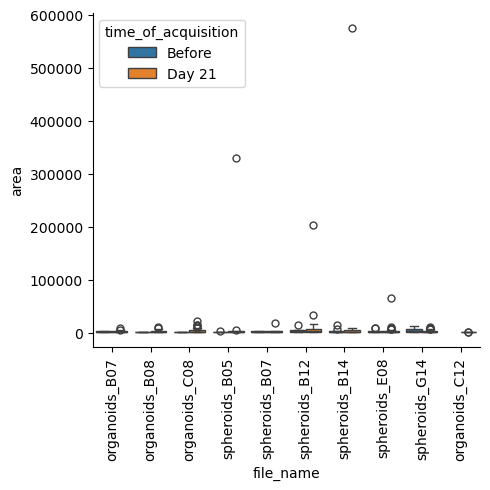

In [15]:
g = sns.catplot(data=master_df, x='file_name', y='area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)#, ha="right")
plt.tight_layout()

## Plot circularity boxplots

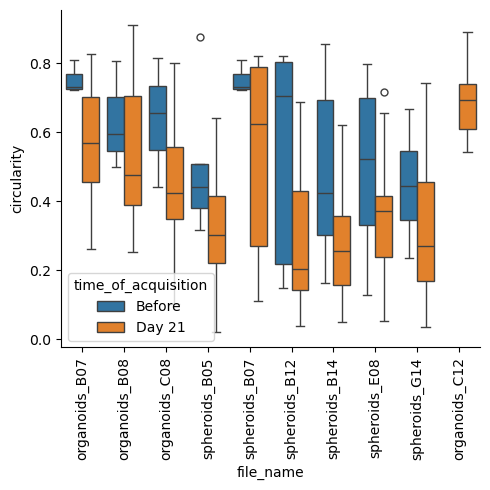

In [16]:
g = sns.catplot(data=master_df, x='file_name', y='circularity', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)#, ha="right")
plt.tight_layout()

## Plot log of area boxplots

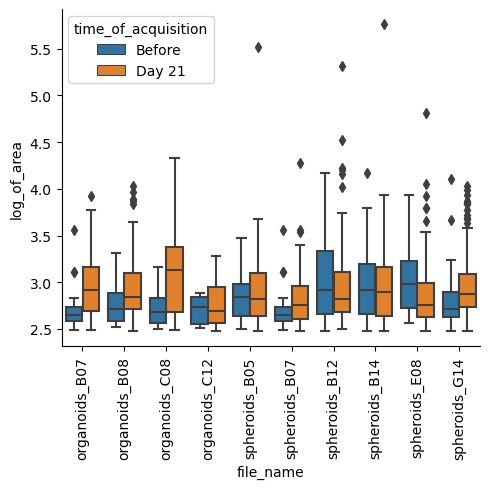

In [20]:
g = sns.catplot(data=master_df, x='file_name', y='log_of_area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)#, ha="right")
plt.tight_layout()

## Display each file in a different plot

Difference between log of areas for each file (before and after):

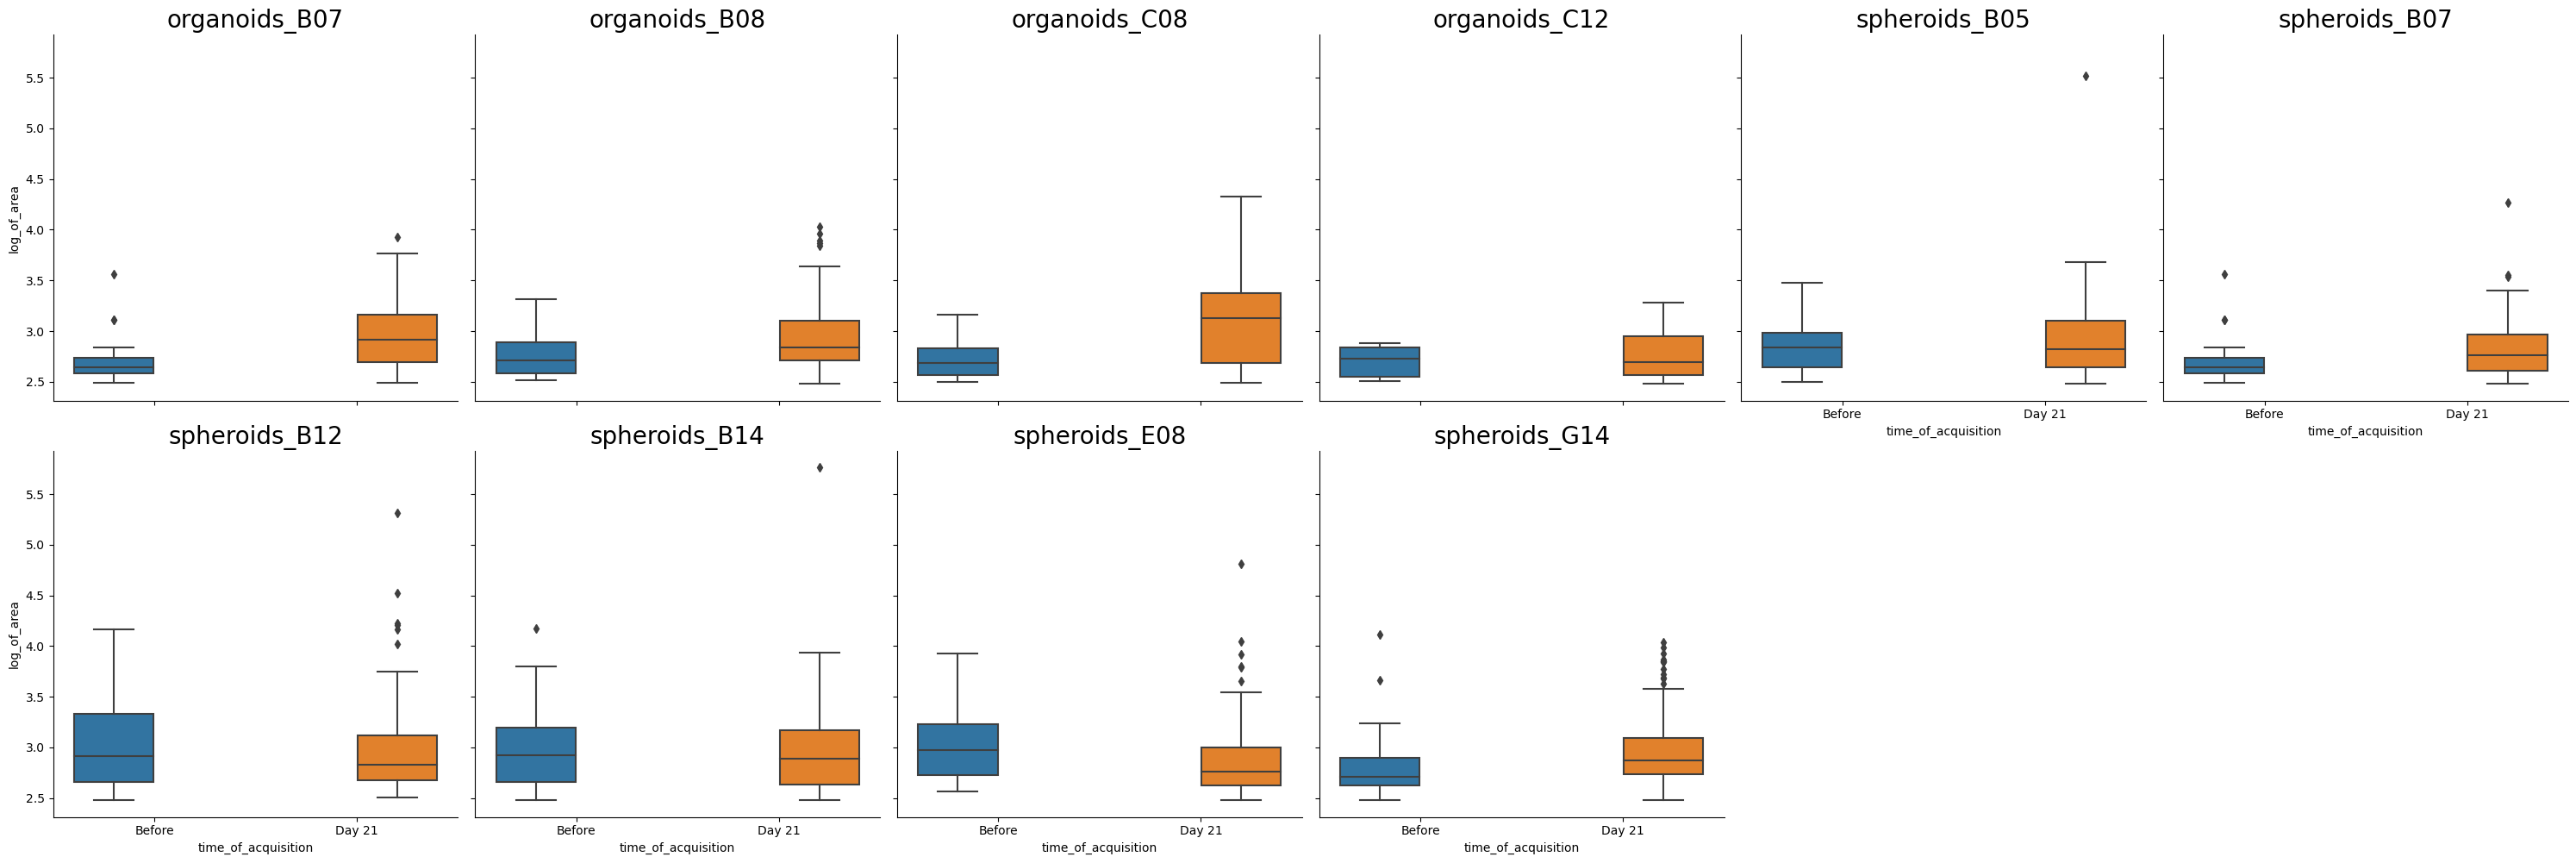

In [38]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='log_of_area', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)

Difference between circularity for each file (before and after):

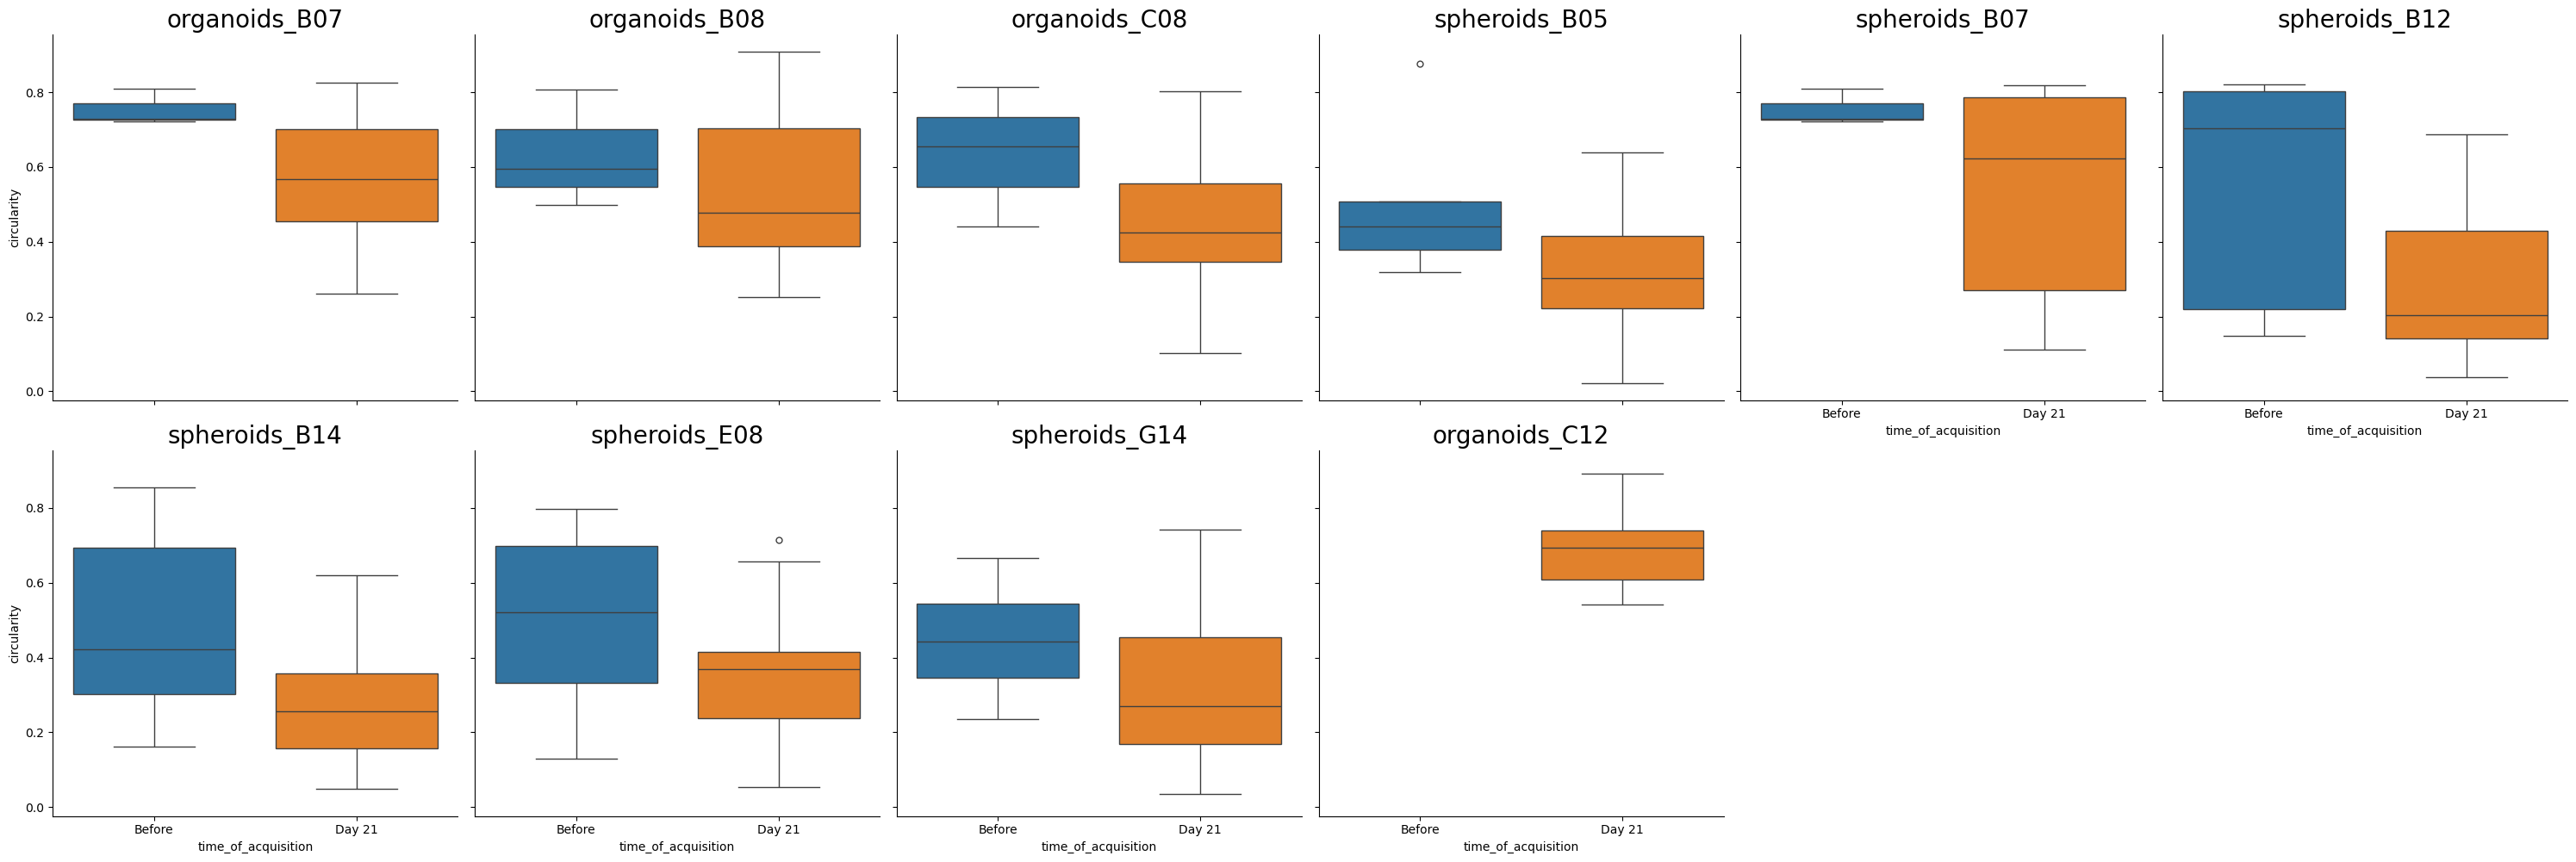

In [17]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='circularity', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)